# Image Classification: Cats vs Dogs

In [1]:
from __future__ import print_function
import os
import zipfile
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import pandas as pd
import tensorflow as tf
import tempfile
import seaborn as sns
import itertools
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.metrics import precision_recall_curve
import urllib
import requests

from tensorflow.keras import layers
from tensorflow.keras import Model


print('Modules are imported.')

Modules are imported.


In [2]:
dogsvcats_url = 'https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip'

current_dir = os.getcwd()
# req = requests.get(dogsvcats_url)

urllib.request.urlretrieve(dogsvcats_url,current_dir + "/data/cats_and_dogs_filtered.zip")

# with open('/data/cats_and_dogs_filtered.zip','wb') as code:
#     code.write(req.content)

('/Users/dhensle/Documents/dabbles-in-ML/google_course/data/cats_and_dogs_filtered.zip',
 <http.client.HTTPMessage at 0x1a283a5e48>)

In [3]:
local_zip = current_dir + '/data/cats_and_dogs_filtered.zip'
zip_ref = zipfile.ZipFile(local_zip,'r')
zip_ref.extractall(current_dir + '/data')
zip_ref.close()


In [4]:
base_dir = current_dir + '/data/cats_and_dogs_filtered'
train_dir = os.path.join(base_dir,'train')
print(train_dir)
validation_dir = os.path.join(base_dir,'validation')

train_cats_dir = os.path.join(train_dir,'cats')
train_dogs_dir = os.path.join(train_dir,'dogs')

validation_cats_dir = os.path.join(validation_dir,'cats')
validation_dogs_dir = os.path.join(validation_dir,'dogs')



/Users/dhensle/Documents/dabbles-in-ML/google_course/data/cats_and_dogs_filtered/train


In [15]:
train_cat_fnames = os.listdir(train_cats_dir)
print (train_cat_fnames[:10])

train_dog_fnames = os.listdir(train_dogs_dir)
train_dog_fnames.sort()
print(train_dog_fnames[:10])

['cat.952.jpg', 'cat.946.jpg', 'cat.6.jpg', 'cat.749.jpg', 'cat.991.jpg', 'cat.985.jpg', 'cat.775.jpg', 'cat.761.jpg', 'cat.588.jpg', 'cat.239.jpg']
['dog.0.jpg', 'dog.1.jpg', 'dog.10.jpg', 'dog.100.jpg', 'dog.101.jpg', 'dog.102.jpg', 'dog.103.jpg', 'dog.104.jpg', 'dog.105.jpg', 'dog.106.jpg']


In [16]:
print ('total training cat images:', len(os.listdir(train_cats_dir)))
print ('total training dog images:', len(os.listdir(train_dogs_dir)))
print ('total validation cat images:', len(os.listdir(validation_cats_dir)))
print ('total validation dog images:', len(os.listdir(validation_dogs_dir)))

total training cat images: 1000
total training dog images: 1000
total validation cat images: 500
total validation dog images: 500


In [17]:
nrows = 4 # Plot parameters 
ncols = 4
pic_index = 0 # index for iterating over images

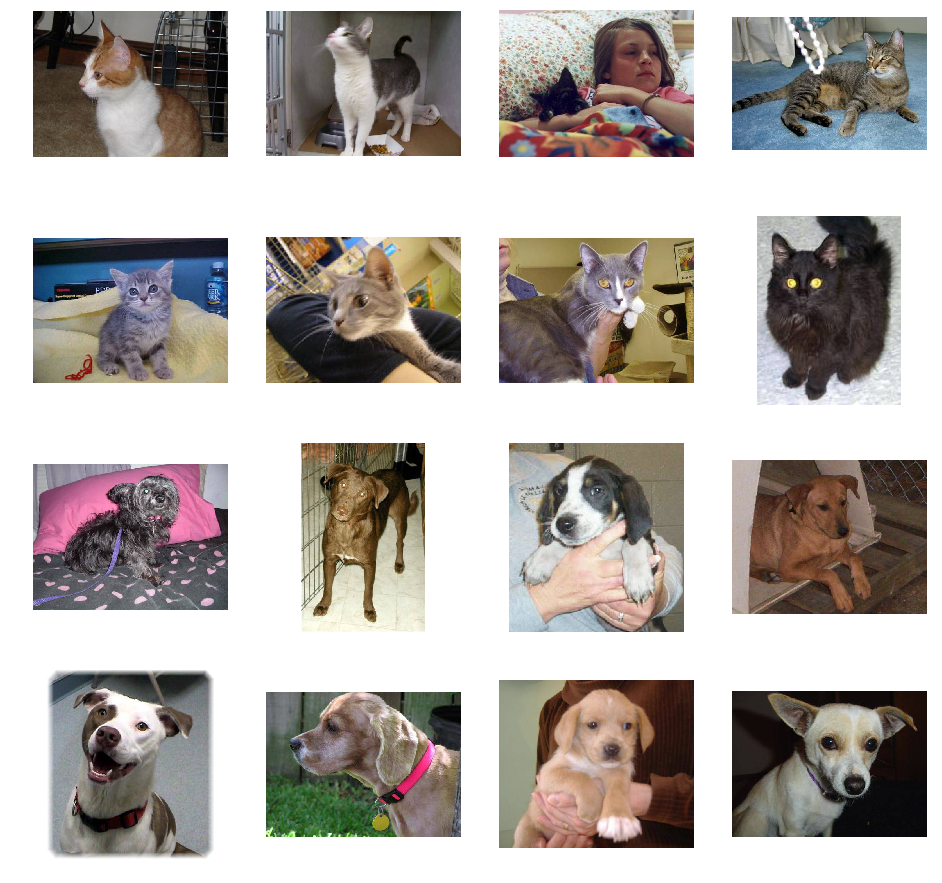

In [18]:
fig = plt.gcf()
fig.set_size_inches(ncols*4, nrows * 4)

pic_index += 8
next_cat_pix = [os.path.join(train_cats_dir, fname)
               for fname in train_cat_fnames[pic_index-8:pic_index]]
next_dog_pix = [os.path.join(train_dogs_dir,fname)
               for fname in train_dog_fnames[pic_index-8:pic_index]]
# print("next_cat_pix = " + next_cat_pix)

for i, img_path in enumerate(next_cat_pix+next_dog_pix):
    sp = plt.subplot(nrows, ncols, i + 1)
    sp.axis('Off')
    img = mpimg.imread(img_path)
    plt.imshow(img)
    
plt.show()

In [19]:
#images are 150x150 pixels, and 3 for the RGB color channels
img_input = layers.Input(shape=(150,150,3))

#First Conv extracts 16 filters, 3x3 ea followed by max-pooling layer with 2x2 window
x = layers.Conv2D(16,3, activation='relu')(img_input)
x = layers.MaxPooling2D(2)(x)

#Second Conv extracts 32 filters, 3x3 ea followed by max-pooling layer with 2x2 window
x = layers.Conv2D(32,3, activation='relu')(x)
x = layers.MaxPooling2D(2)(x)

#Third Conv extracts 64 filters, 3x3 ea followed by max-pooling layer with 2x2 window
x = layers.Conv2D(64,3, activation='relu')(x)
x = layers.MaxPooling2D(2)(x)


In [20]:
#Flatten feature map to 1-dim tensor so we can add fully connected layers
x = layers.Flatten()(x)

#Fully connected layer with reLu activation and 512 hidden units
x = layers.Dense(512, activation='relu')(x)

#Create output layer with single node and sigmoid activation
output = layers.Dense(1, activation='sigmoid')(x)

#Create model:
# input = input feature map
# output = input feature map + stacked convolution/maxpooling layers + fully connected layer + sigmoid output layer
model = Model(img_input, output)

In [11]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 150, 150, 3)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 148, 148, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 74, 74, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 72, 72, 32)        4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 36, 36, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 34, 34, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 17, 17, 64)        0         
__________

In [23]:
from tensorflow.keras.optimizers import RMSprop

model.compile(loss='binary_crossentropy',
             optimizer=RMSprop(lr=.001),
             metrics=['acc'])

In [24]:
#building generators to yield batches of 20 images of size 150x150 pixels and their binary labels
# also normalizing pixel values from [0,255] to [0,1]

from tensorflow.keras.preprocessing.image import ImageDataGenerator

#All images rescaled by 1./255
train_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

#Flow training images in batches of 20 using train_datagen generator
train_generator = train_datagen.flow_from_directory(
    train_dir, #source directory
    target_size=(150,150), #Resizing all images to 150x150 pizels
    batch_size=20,
    class_mode='binary'
)

#Flow validation images in batches of 20 using test_datagen generator
validation_generator = test_datagen.flow_from_directory(
    validation_dir, #source directory
    target_size=(150,150), #Resizing all images to 150x150 pizels
    batch_size=20,
    class_mode='binary'
)


Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [25]:
#training on all 2000 images for 15 epochs and validate on all 1000 test images
history = model.fit_generator(
    train_generator,
    steps_per_epoch=100, #2000 images = batch_size * steps
    epochs=15,
    validation_data=validation_generator,
    validation_steps=50, #1000 images = batch_size * steps
    verbose=2)

Epoch 1/15
50/50 [==============================] - 10s 196ms/step - loss: 0.6531 - acc: 0.6050
 - 62s - loss: 0.7753 - acc: 0.5555 - val_loss: 0.6531 - val_acc: 0.6050
Epoch 2/15
50/50 [==============================] - 7s 141ms/step - loss: 0.6893 - acc: 0.5950
 - 58s - loss: 0.6572 - acc: 0.6255 - val_loss: 0.6893 - val_acc: 0.5950
Epoch 3/15
50/50 [==============================] - 7s 144ms/step - loss: 0.6072 - acc: 0.6860
 - 53s - loss: 0.5800 - acc: 0.6955 - val_loss: 0.6072 - val_acc: 0.6860
Epoch 4/15
50/50 [==============================] - 7s 138ms/step - loss: 0.5660 - acc: 0.7250
 - 53s - loss: 0.5019 - acc: 0.7625 - val_loss: 0.5660 - val_acc: 0.7250
Epoch 5/15
50/50 [==============================] - 7s 138ms/step - loss: 0.6140 - acc: 0.7150
 - 54s - loss: 0.3960 - acc: 0.8190 - val_loss: 0.6140 - val_acc: 0.7150
Epoch 6/15
50/50 [==============================] - 7s 137ms/step - loss: 0.6696 - acc: 0.7170
 - 53s - loss: 0.3144 - acc: 0.8665 - val_loss: 0.6696 - val_acc

/Applications/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:35: RuntimeWarning: invalid value encountered in true_divide


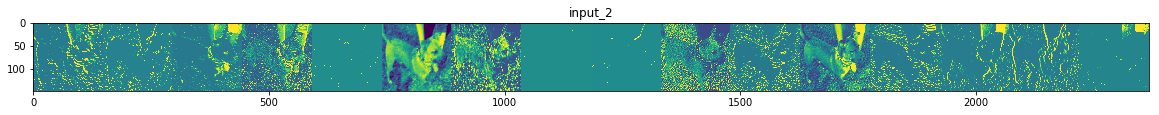

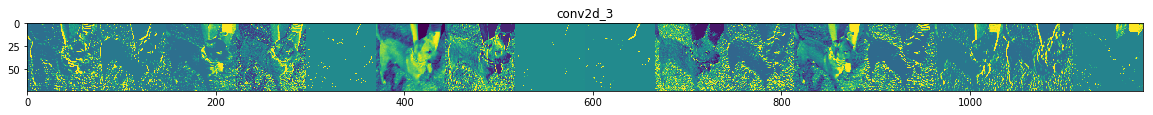

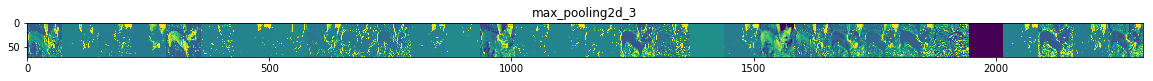

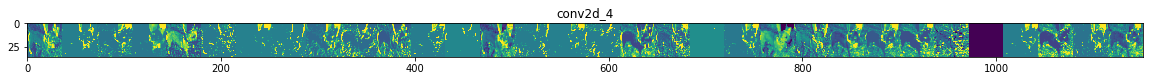

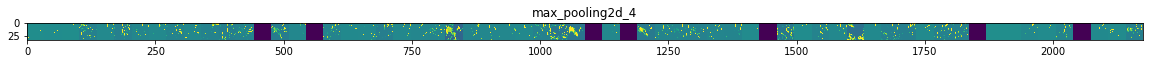

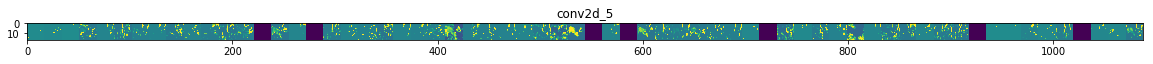

In [26]:
import random
from tensorflow.keras.preprocessing.image import img_to_array, load_img

#defining new model that will take an image as imput, and output
# intermediate representations for all layers in the previous model
successive_outputs = [layer.output for layer in model.layers[1:]]
visualization_model = Model(img_input, successive_outputs)

#preparing random image of cat or dog from training set
cat_img_files = [os.path.join(train_cats_dir, f) for f in train_cat_fnames]
dog_img_files = [os.path.join(train_dogs_dir,f) for f in train_dog_fnames]
img_path = random.choice(cat_img_files + dog_img_files)

img = load_img(img_path, target_size=(150,150)) #this is a PIL image
x = img_to_array(img) #numpy array with shape (150,150,3)
x = x.reshape((1,)+x.shape) #numpy array with shape (1,150,150,3)
x/= 255

#running the image through the network to obtain all intermediate representations
successive_feature_maps = visualization_model.predict(x)

layer_names = [layer.name for layer in model.layers]

#displaying representations
for layer_name, feature_map in zip (layer_names, successive_feature_maps):
    if len(feature_map.shape) == 4:
        #just doing conv/maxpool layers, not fully-connected layers
        n_features = feature_map.shape[-1] # number of features in feature map
        size = feature_map.shape[1] # feature map has shape (1, size, size, n_features)
        
        display_grid = np.zeros((size, size * n_features))
        for i in range(n_features):
            x = feature_map[0,:,:,i]
            x -= x.mean()
            x /= x.std()
            x*=64
            x+= 128
            x = np.clip(x,0,255).astype('uint8')
            display_grid[:,i*size:(i + 1) * size] = x
        scale = 20./n_features
        plt.figure(figsize =(scale* n_features, scale))
        plt.title(layer_name)
        plt.grid(False)
        plt.imshow(display_grid, aspect = 'auto', cmap = 'viridis')
    

Text(0.5, 1.0, 'Trailing and validation loss')

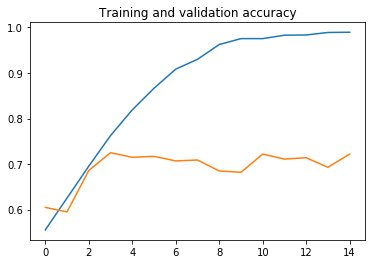

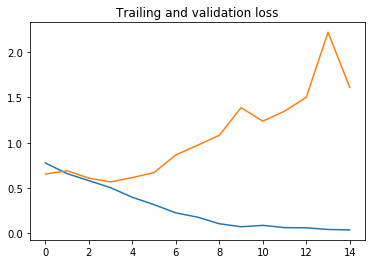

In [27]:
# list of accuracy results on training and test data for each training epoch
acc = history.history['acc']
val_acc = history.history['val_acc']

# list of loss results on training and test data for each training epoch
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc)
plt.plot(epochs, val_acc)
plt.title('Training and validation accuracy')

plt.figure()

plt.plot(epochs,loss)
plt.plot(epochs, val_loss)
plt.title('Trailing and validation loss')


###### We are overfitting.  Trying two techniques to combat this: data augmentation and dropout regularization

In [28]:
datagen = ImageDataGenerator(
    rotation_range=40, #randomly rotate picture between [0,40] degrees
    width_shift_range=0.2, #translate picture horizontally
    height_shift_range=0.2, #translate picture vertically
    shear_range=0.2, # shear transformation
    zoom_range=0.2, # zooming in on pictures
    horizontal_flip=True, #randomly flips half of the pictures horizontally
    fill_mode='nearest' # strategy for filling in newly created pixels after transformations
)


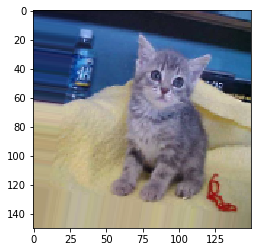

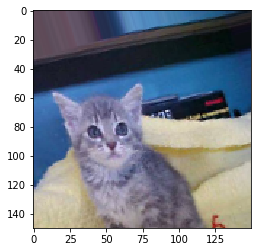

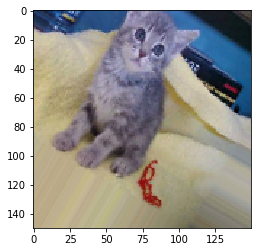

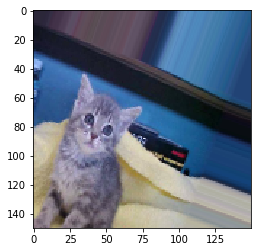

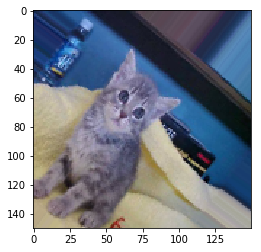

In [29]:
from tensorflow.keras.preprocessing.image import array_to_img

img_path = os.path.join(train_cats_dir, train_cat_fnames[4])
img = load_img(img_path, target_size=(150,150))
x = img_to_array(img) #numpy array with shape (150,150,3)
x = x.reshape((1,) + x.shape) #numpy array with shape (1,150,150,3)

#the .flow() command generates batches of randomly transformed images
#  will loop indefinitely, so need to break
i = 0
for batch in datagen.flow(x, batch_size=1):
    plt.figure(i)
    imgplot = plt.imshow(array_to_img(batch[0]))
    i+=1
    if i % 5 == 0:
        break

In [30]:
#adding image modification to our ImageDataGenerator
train_datagen = ImageDataGenerator(
    rescale = 1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

#Validation Data should not be modified!
test_datagen = ImageDataGenerator(rescale=1./255)

#Flow training images in batches of 32
train_generator = train_datagen.flow_from_directory(
    train_dir, #source directory for training images
    target_size=(150,150), #all images resized to 150x150
    batch_size=20,
    class_mode='binary' # need binary labels for binary_crossentropy loss
)

#Flow validation images in batches of 32
validation_generator = test_datagen.flow_from_directory(
    validation_dir,
    target_size=(150,150),
    batch_size=20,
    class_mode='binary'
)



Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [31]:
#training on all 2000 images for 15 epochs and validate on all 1000 test images
history = model.fit_generator(
    train_generator,
    steps_per_epoch=100, #2000 images = batch_size * steps
    epochs=15,
    validation_data=validation_generator,
    validation_steps=50, #1000 images = batch_size * steps
    verbose=2)

Epoch 1/15
50/50 [==============================] - 9s 178ms/step - loss: 0.5892 - acc: 0.6580
 - 66s - loss: 0.7278 - acc: 0.6220 - val_loss: 0.5892 - val_acc: 0.6580
Epoch 2/15
50/50 [==============================] - 7s 147ms/step - loss: 0.5319 - acc: 0.7430
 - 73s - loss: 0.6303 - acc: 0.6435 - val_loss: 0.5319 - val_acc: 0.7430
Epoch 3/15
50/50 [==============================] - 10s 190ms/step - loss: 0.5485 - acc: 0.7160
 - 65s - loss: 0.6097 - acc: 0.6775 - val_loss: 0.5485 - val_acc: 0.7160
Epoch 4/15
50/50 [==============================] - 9s 177ms/step - loss: 0.5238 - acc: 0.7420
 - 72s - loss: 0.5981 - acc: 0.6870 - val_loss: 0.5238 - val_acc: 0.7420
Epoch 5/15
50/50 [==============================] - 11s 212ms/step - loss: 0.5435 - acc: 0.7390
 - 91s - loss: 0.6021 - acc: 0.6825 - val_loss: 0.5435 - val_acc: 0.7390
Epoch 6/15
50/50 [==============================] - 9s 171ms/step - loss: 0.5554 - acc: 0.7230
 - 67s - loss: 0.5802 - acc: 0.7120 - val_loss: 0.5554 - val_ac

Text(0.5, 1.0, 'Trailing and validation loss')

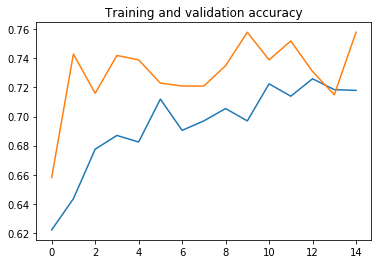

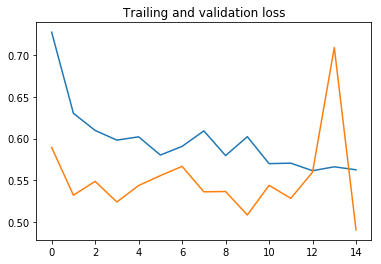

In [32]:
# list of accuracy results on training and test data for each training epoch
acc = history.history['acc']
val_acc = history.history['val_acc']

# list of loss results on training and test data for each training epoch
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc)
plt.plot(epochs, val_acc)
plt.title('Training and validation accuracy')

plt.figure()

plt.plot(epochs,loss)
plt.plot(epochs, val_loss)
plt.title('Trailing and validation loss')

###### Adding dropout right before final classification layer

In [33]:
#Input feature map is 150x150x3(RGB color)
img_input = layers.Input(shape=(150,150,3))

#first conv extracts 16 filters that are 3x3 followed by 2x2 max-pooling window
x = layers.Conv2D(16,3, activation='relu')(img_input)
x = layers.MaxPooling2D(2)(x)

#Second conv extracts 32 filters that are 3x3 followed by 2x2 max-pooling window
x = layers.Conv2D(32,3, activation='relu')(x)
x = layers.MaxPooling2D(2)(x)

#Third conv extracts 64 filters that are 3x3 followed by 2x2 max-pooling window
x = layers.Conv2D(64,3,activation='relu')(x)
x = layers.MaxPooling2D(2)(x)

#Flatten to 1-dim tensor
x = layers.Flatten()(x)

#create fully connected layer with ReLU activation and 512 hidden units
x = layers.Dense(512, activation='relu')(x)

#Dropout layer with rate 0.5
x = layers.Dropout(0.5)(x)

#Output layer with single node and sigmoid activation
output = layers.Dense(1, activation='sigmoid')(x)

# Configure and compile model
model = Model(img_input, output)
model.compile(loss='binary_crossentropy',
             optimizer=RMSprop(lr=.001),
             metrics=['acc'])

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [34]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 150, 150, 3)       0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 148, 148, 16)      448       
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 74, 74, 16)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 72, 72, 32)        4640      
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 36, 36, 32)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 34, 34, 64)        18496     
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 17, 17, 64)        0         
__________

In [35]:
#training on all 2000 images for 15 epochs and validate on all 1000 test images
history = model.fit_generator(
    train_generator,
    steps_per_epoch=100, #2000 images = batch_size * steps
    epochs=15,
    validation_data=validation_generator,
    validation_steps=50, #1000 images = batch_size * steps
    verbose=2)

Epoch 1/15
50/50 [==============================] - 8s 162ms/step - loss: 0.6901 - acc: 0.5190
 - 62s - loss: 0.7632 - acc: 0.5215 - val_loss: 0.6901 - val_acc: 0.5190
Epoch 2/15
50/50 [==============================] - 8s 159ms/step - loss: 0.6581 - acc: 0.6160
 - 70s - loss: 0.6925 - acc: 0.5485 - val_loss: 0.6581 - val_acc: 0.6160
Epoch 3/15
50/50 [==============================] - 13s 251ms/step - loss: 0.6193 - acc: 0.6530
 - 73s - loss: 0.6683 - acc: 0.5930 - val_loss: 0.6193 - val_acc: 0.6530
Epoch 4/15
50/50 [==============================] - 9s 186ms/step - loss: 0.5876 - acc: 0.6900
 - 64s - loss: 0.6508 - acc: 0.6205 - val_loss: 0.5876 - val_acc: 0.6900
Epoch 5/15
50/50 [==============================] - 8s 155ms/step - loss: 0.5709 - acc: 0.7080
 - 75s - loss: 0.6284 - acc: 0.6515 - val_loss: 0.5709 - val_acc: 0.7080
Epoch 6/15
50/50 [==============================] - 9s 174ms/step - loss: 0.5728 - acc: 0.7050
 - 65s - loss: 0.6281 - acc: 0.6555 - val_loss: 0.5728 - val_acc

Text(0.5, 1.0, 'Trailing and validation loss')

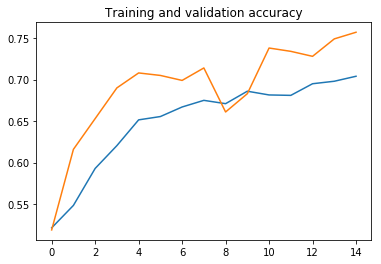

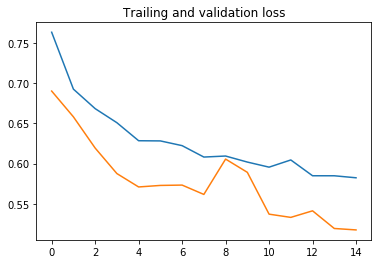

In [36]:
# list of accuracy results on training and test data for each training epoch
acc = history.history['acc']
val_acc = history.history['val_acc']

# list of loss results on training and test data for each training epoch
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc)
plt.plot(epochs, val_acc)
plt.title('Training and validation accuracy')

plt.figure()

plt.plot(epochs,loss)
plt.plot(epochs, val_loss)
plt.title('Trailing and validation loss')

###### Using google Inception v3 model to do feature extraction

In [37]:
curr_dir = os.getcwd()

inceptionv3_url = "https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5"

urllib.request.urlretrieve(inceptionv3_url,curr_dir + '/data/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5')


('/Users/dhensle/Documents/dabbles-in-ML/google_course/data/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5',
 <http.client.HTTPMessage at 0x1a29357dd8>)

In [38]:
from tensorflow.keras.applications.inception_v3 import InceptionV3

local_weights_file = curr_dir + "/data/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5"
pre_trained_model = InceptionV3(
    input_shape=(150,150,3),
    include_top=False,
    weights=None)
pre_trained_model.load_weights(local_weights_file)

In [39]:
# Making inception model weights not trainable
for layer in pre_trained_model.layers:
    layer.trainable = False

In [40]:
# Using the 'mixed7' layer of Inception v3 to do the feature extraction (7x7 feature map)
last_layer = pre_trained_model.get_layer('mixed7')
print('last layer output shape:', last_layer.output_shape)
last_output = last_layer.output

last layer output shape: (None, 7, 7, 768)


In [41]:
# Appending a fully connected classifier on top of last_output

#Flatten output layer to 1-dim
x = layers.Flatten()(last_output)

# Fully connected layer with 1,024 hidden units and ReLU activation
x = layers.Dense(1024, activation='relu')(x)

#Adding dropout layer
x = layers.Dropout(0.20)(x)

#Final output sigmoid classifier
x = layers.Dense(1, activation='sigmoid')(x)

#Configure and compile model
model = Model(pre_trained_model.input, x)
model.compile(loss='binary_crossentropy',
             optimizer=RMSprop(lr=.0001),
             metrics=['acc'])


In [42]:
history = model.fit_generator(
    train_generator, #still using image modification from before
    steps_per_epoch=100,
    epochs=2,
    validation_data=validation_generator,
    validation_steps=50,
    verbose=2)

Epoch 1/2
50/50 [==============================] - 53s 1s/step - loss: 0.2742 - acc: 0.9110
 - 220s - loss: 0.4955 - acc: 0.7735 - val_loss: 0.2742 - val_acc: 0.9110
Epoch 2/2
50/50 [==============================] - 47s 947ms/step - loss: 0.2008 - acc: 0.9510
 - 215s - loss: 0.3568 - acc: 0.8430 - val_loss: 0.2008 - val_acc: 0.9510


###### Fine-Tuning Inception V3 model -- setting top layers to be trainable

In [43]:
# Unfreezing all layers belonging to the mixed7 module
from tensorflow.keras.optimizers import SGD

unfreeze = False

for layer in pre_trained_model.layers:
    if unfreeze:
        layer.trainable=True
    if layer.name=='mixed6':
        unfreeze = True
        
#Using SGD optimizer with very low learning rate
model.compile(loss='binary_crossentropy',
             optimizer=SGD(
                 lr=.00001,
                 momentum=0.9),
             metrics=['acc'])

In [44]:
history = model.fit_generator(
    train_generator,
    steps_per_epoch=100,
    epochs=50,
    validation_data=validation_generator,
    validation_steps=50,
    verbose=2)

Epoch 1/50
50/50 [==============================] - 51s 1s/step - loss: 0.2242 - acc: 0.9500
 - 216s - loss: 0.4121 - acc: 0.8240 - val_loss: 0.2242 - val_acc: 0.9500
Epoch 2/50
50/50 [==============================] - 64s 1s/step - loss: 0.2432 - acc: 0.9470
 - 288s - loss: 0.3231 - acc: 0.8535 - val_loss: 0.2432 - val_acc: 0.9470
Epoch 3/50
50/50 [==============================] - 44s 879ms/step - loss: 0.2559 - acc: 0.9440
 - 217s - loss: 0.3100 - acc: 0.8675 - val_loss: 0.2559 - val_acc: 0.9440
Epoch 4/50
50/50 [==============================] - 52s 1s/step - loss: 0.2623 - acc: 0.9440
 - 244s - loss: 0.2876 - acc: 0.8780 - val_loss: 0.2623 - val_acc: 0.9440
Epoch 5/50
50/50 [==============================] - 50s 1s/step - loss: 0.2676 - acc: 0.9410
 - 234s - loss: 0.2770 - acc: 0.8845 - val_loss: 0.2676 - val_acc: 0.9410
Epoch 6/50
50/50 [==============================] - 55s 1s/step - loss: 0.2705 - acc: 0.9390
 - 256s - loss: 0.2769 - acc: 0.8740 - val_loss: 0.2705 - val_acc: 0.

50/50 [==============================] - 45s 910ms/step - loss: 0.2685 - acc: 0.9400
 - 205s - loss: 0.2646 - acc: 0.8840 - val_loss: 0.2685 - val_acc: 0.9400
Epoch 50/50
50/50 [==============================] - 44s 888ms/step - loss: 0.2660 - acc: 0.9410
 - 188s - loss: 0.2618 - acc: 0.8895 - val_loss: 0.2660 - val_acc: 0.9410


Text(0.5, 1.0, 'Trailing and validation loss')

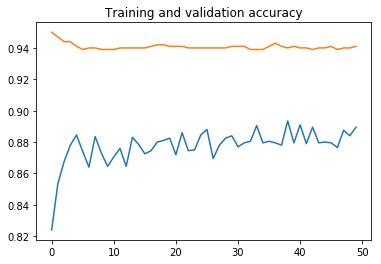

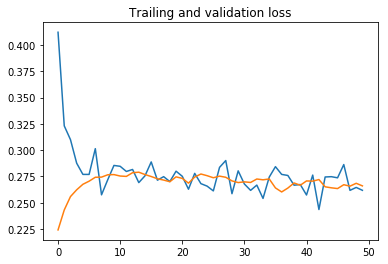

In [45]:
# list of accuracy results on training and test data for each training epoch
acc = history.history['acc']
val_acc = history.history['val_acc']

# list of loss results on training and test data for each training epoch
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc)
plt.plot(epochs, val_acc)
plt.title('Training and validation accuracy')

plt.figure()

plt.plot(epochs,loss)
plt.plot(epochs, val_loss)
plt.title('Trailing and validation loss')

###### We have achieved roughly 94% accuracy on the validation set!